# Examples of how to access s3 datasets
ESA Worldcover, MAAP, TerraPulse S3 buckets from ILAB Daskhub

Authors: JL 03-03-2022, PM 2022

In [2]:
!pip install -U contextily

  Using cached contextily-1.2.0-py3-none-any.whl (16 kB)
  Using cached contextily-1.1.0-py3-none-any.whl (24 kB)


In [1]:
import s3fs
import os
import boto3
import pandas as pd
import geopandas as gpd
import sys
sys.path.append('/efs/pmontesa/code/geoscitools')
sys.path.append('/home/pmontesa/code/geoscitools')
import maplib
import rasterio
import contextily as ctx

ModuleNotFoundError: No module named 's3fs'

In [2]:
def test_raster_read(s3_url, ANON=True, PROFILE_NAME='boreal_pub'):
    import rasterio
    if ANON:
        session = rasterio.env.Env(AWS_NO_SIGN_REQUEST='YES')
    else:
        session = rasterio.env.Env(profile_name=PROFILE_NAME)
    with session:
        with rasterio.open(s3_url, mode='r') as dataset:
            print(dataset.profile)

In [3]:
# s3 = boto3.resource('s3')
# bucket = s3.Bucket('copernicus-dem-30m')
# bucket_files = [s3_file.key for s3_file in bucket.objects.all()]
# bucket_files

### Access to s3 bucket for dataset in AWS open data registry
https://gist.github.com/wildintellect/151c80e291eddd249b7e171daa291c37

Open datasets on AWS
* https://registry.opendata.aws/esa-worldcover/
* https://registry.opendata.aws/copernicus-dem/

#### Find dataset files within their buckets
Put results of search into dictionaries

In [4]:
s3 = s3fs.S3FileSystem(anon=True)

AWS_DATA_DICT_LIST = [
                {
                'REFERENCE': 'https://registry.opendata.aws/copernicus-dem/',
                'BUCKET' : 'copernicus-dem-30m/2021', 
                'FILES_LIST': None,
                'RASTER_BUCKET': 'copernicus-dem-30m/2021',
                'RASTER_LIST': None
                },
                {
                'REFERENCE': 'https://registry.opendata.aws/esa-worldcover/',
                'BUCKET' : 'esa-worldcover/v100/2020',
                'FILES_LIST': None,
                'RASTER_BUCKET': 'esa-worldcover/v100/2020/map',
                'RASTER_LIST': None
                }
                ]  

for idx, AWS_DATA_DICT in enumerate(AWS_DATA_DICT_LIST):
    
    bucket = AWS_DATA_DICT['BUCKET']
    print(f"Data bucket: {bucket} from {AWS_DATA_DICT['REFERENCE']}")
    searchkey = "*"
    
    # Update dict with a list of all files
    AWS_DATA_DICT.update( {'FILES_LIST': [i.replace(bucket, 's3://'+bucket) for i in s3.glob(os.path.join(bucket, searchkey))] })
    print(f"# of files: {len( AWS_DATA_DICT['FILES_LIST'] )}")
    
    # Update dict with a list of all raster files if raster are in a separate bucket
    if not AWS_DATA_DICT['RASTER_BUCKET'] == bucket:
        bucket = AWS_DATA_DICT['RASTER_BUCKET']
    
    AWS_DATA_DICT.update( {'RASTER_LIST': [i.replace(bucket, 's3://'+bucket) for i in s3.glob(os.path.join(bucket, searchkey) + '.tif')] })
    print(f"# of raster files in {AWS_DATA_DICT['RASTER_BUCKET']}: {len( AWS_DATA_DICT['RASTER_LIST'] )}")
    

Data bucket: copernicus-dem-30m/2021 from https://registry.opendata.aws/copernicus-dem/
# of files: 26453
# of raster files in copernicus-dem-30m/2021: 0
Data bucket: esa-worldcover/v100/2020 from https://registry.opendata.aws/esa-worldcover/
# of files: 5
# of raster files in esa-worldcover/v100/2020/map: 2651


#### Examine the dictionary of a result and get a file list 

In [5]:
d = AWS_DATA_DICT_LIST[1]

FILES_LIST = d['FILES_LIST']

#### Examine a spatial file from a result (get geojson)

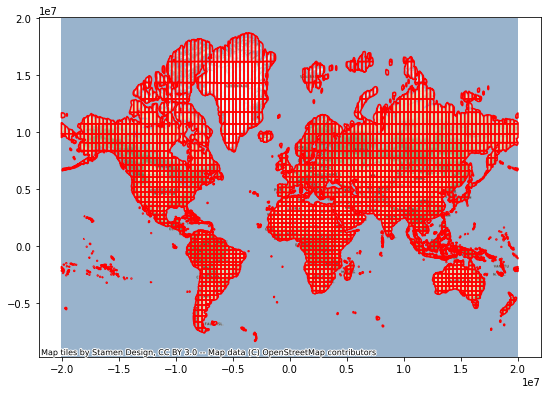

In [6]:
esa_worldcover_2020_grid = [f for f in FILES_LIST if '.geojson' in f][0]
esa_worldcover_2020_grid_gdf = gpd.read_file(s3.open(esa_worldcover_2020_grid, mode = 'r') )
ax = esa_worldcover_2020_grid_gdf.to_crs(3857).boundary.plot(color="red", figsize=(9, 9))
ctx.add_basemap(ax)
#esa_worldcover_2020_grid_gdf

In [7]:
esa_worldcover_2020_grid_gdf.head()

ll_tile                                           geometry
0  S54E168  POLYGON ((168.80786 -52.75980, 168.79761 -52.7...
1  S54E165  POLYGON ((166.50177 -51.00000, 166.46563 -51.0...
2  S57E159  POLYGON ((159.00000 -54.17474, 159.05881 -54.1...
3  S57E156  POLYGON ((159.00000 -55.01738, 158.96296 -55.0...
4  S45E144  POLYGON ((147.00000 -42.00000, 147.00000 -43.9...

#### Subset ESA Worldcover files by a country

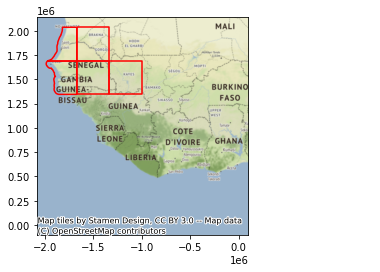

In [8]:
# load natural earth low res shapefile
ne = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# get AOI geometry
country = 'Senegal'
geom = ne[ne.name == country].iloc[0].geometry

# get tiles intersecting AOI
tiles = esa_worldcover_2020_grid_gdf[esa_worldcover_2020_grid_gdf.intersects(geom)]

ax = tiles.to_crs(3857).boundary.plot(color='red')
ax = ne[ne.name == country].boundary.plot(ax=ax, color='black')
ctx.add_basemap(ax)

#### Print some raster tile filenames

In [9]:
# From dictionary
d['RASTER_LIST'][0:5]

['s3://esa-worldcover/v100/2020/map/ESA_WorldCover_10m_2020_v100_N00E006_Map.tif',
 's3://esa-worldcover/v100/2020/map/ESA_WorldCover_10m_2020_v100_N00E009_Map.tif',
 's3://esa-worldcover/v100/2020/map/ESA_WorldCover_10m_2020_v100_N00E012_Map.tif',
 's3://esa-worldcover/v100/2020/map/ESA_WorldCover_10m_2020_v100_N00E015_Map.tif',
 's3://esa-worldcover/v100/2020/map/ESA_WorldCover_10m_2020_v100_N00E018_Map.tif']

In [10]:
# From geodataframe subset in AOI
tiles.ll_tile.to_list()[0:5]

['N12W012', 'N12W015', 'N12W018', 'N15W018', 'N15W015']

#### Download some tiles - if you must

In [11]:
s3_url_prefix = "https://esa-worldcover.s3.eu-central-1.amazonaws.com"
out_dir = '/panfs/ccds02/nobackup/people/pmontesa/userfs02/data/worldcover/2020/v1' #'/efs/projects/forest_height/test_out/senegal'
if True:
    # use requests library to download them
    import requests
    from tqdm.auto import tqdm  # provides a progressbar
    try:
        os.makedirs(out_dir)
    except OSError:
        pass
    for tile in tqdm(tiles.ll_tile):
        url = f"{s3_url_prefix}/v100/2020/map/ESA_WorldCover_10m_2020_v100_{tile}_Map.tif\n"
        r = requests.get(url, allow_redirects=True)
        out_fn = f"{out_dir}/ESA_WorldCover_10m_2020_v100_{tile}_Map.tif"
        with open(out_fn, 'wb') as f:
            f.write(r.content)

  0%|          | 0/5 [00:00<?, ?it/s]

#### Check that you can read an s3 raster

In [ ]:
from rasterio.plot import *
fn = [os.path.join('s3://esa-worldcover', f'v100/2020/map/ESA_WorldCover_10m_2020_v100_{tile}_Map.tif') for tile in tiles.ll_tile.to_list()][0]
print(fn)

with rasterio.Env(AWS_NO_SIGN_REQUEST='YES'):
    with rasterio.open(fn) as dataset:
        print(dataset.meta)
        #show(dataset) #mem issue

s3://esa-worldcover/v100/2020/map/ESA_WorldCover_10m_2020_v100_N42W075_Map.tif
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 36000, 'height': 36000, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(8.333333333333333e-05, 0.0, -75.0,
       0.0, -8.333333333333333e-05, 45.0)}


In [9]:
esa_worldcover_2020_grid_gdf.iloc[8].geometry.bounds

(166.1664839325446, -48.0, 168.0, -45.0)

In [10]:
maplib.MAP_LAYER_FOLIUM(esa_worldcover_2020_grid_gdf, LAYER_COL_NAME='ll_tile', zoom_start=2, lon_start=0)

In [45]:
import pyproj
crs_sin = pyproj.crs.CRS.from_wkt('PROJCS["unnamed",GEOGCS["unnamed ellipse",DATUM["unknown",SPHEROID["unnamed",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

#crs_sin = pyproj.crs.CRS(
#    #proj='utm', zone=10, ellps='WGS84'
#    proj='sinu', lon_0=0, x_0=0, y_0=0, a=6371007.181, b=6371007.181, units='m'# +no_defs
 #                   )
crs_sin

<Derived Projected CRS: PROJCS["unnamed",GEOGCS["unnamed ellipse",DATUM["u ...>
Name: unnamed
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Sinusoidal
Datum: unknown
- Ellipsoid: unnamed
- Prime Meridian: Greenwich

In [ ]:
z = gpd.read_file('/efs/projects/forest_height/footprints_terrapulse-pub-data_boreal-tcc-unclipped.gpkg')

ax = z.to_crs(3857).plot()
ctx.add_basemap(ax)
maplib.MAP_LAYER_FOLIUM(z,  LAYER_COL_NAME='file', zoom_start=2, lon_start=0)

### Access to MAAP products
COGs of biomass, HLS seasonal comps, Topo stacks, ATL08 30m

+ Note: its easier to use the tindex csv lists to get the paths to all the files

In [13]:
%%time
# Following cell is an example to list MAAP S3 buckets
# Note: limited number of buckets are opened to Daskhub; Credentials have been set at admin level 
s3 = s3fs.S3FileSystem()
bucket = "s3://maap-ops-workspace"
#key = "lduncanson/dps_output/run_boreal_biomass_ubuntu/master/2021/10/01/02/47/09/402274/"
#s3.ls(os.path.join(bucket, key))

searchkey_boreal_atl0830m_h5  = 'lduncanson/dps_output/run_rebinning_ubuntu/master/2022/03/**/*.h5'
searchkey_boreal_atl0830m_csv = 'lduncanson/dps_output/run_extract_filter_atl08_ubuntu/master/2022/03/**/*.csv'
searchkey_boreal_tileatl08_csv = 'lduncanson/dps_output/run_tile_atl08_ubuntu/master/2022/0*/**/*.csv'
searchkey_boreal_agb_cogs     = 'lduncanson/dps_output/run_boreal_biomass_ubuntu/master/2021/10/**/*cog.tif'
searchkey_boreal_topo_cogs    = 'nathanmthomas/dps_output/do_topo_stack_3-1-5_ubuntu/ops/2021/09/**/*stack.tif'
#searchkey_boreal_mscomp_cogs = 'nathanmthomas/dps_output/do_landsat_stack_3-1-2_ubuntu/ops/2021/09/**/*.tif'
searchkey_boreal_mscomp_cogs  = 'nathanmthomas/dps_output/do_landsat_stack_3-1-2_ubuntu/master/2022/03/**/*.tif'

searchkey_list = [searchkey_boreal_atl0830m_h5, searchkey_boreal_atl0830m_csv, searchkey_boreal_agb_cogs, searchkey_boreal_topo_cogs, searchkey_boreal_mscomp_cogs]

atl0830m_path_df, atl0830mcsv_path_df, agb_path_df, topo_path_df, mscomp_path_df = [pd.DataFrame(s3.glob( os.path.join(bucket, searchkey)), columns=['maap_path']) for searchkey in searchkey_list]
[print(df.shape) for df in [atl0830m_path_df,atl0830mcsv_path_df, agb_path_df, topo_path_df, mscomp_path_df]]

(47736, 1)
(46379, 1)
(9048, 1)
(3177, 1)
(33, 1)
CPU times: user 1min 21s, sys: 685 ms, total: 1min 21s
Wall time: 2min 16s


[None, None, None, None, None]

#### Make a list of all the tiled ATL08 files from certain subdirs
* exclude certain files

In [ ]:
searchkey_boreal_tileatl08_csv = 'lduncanson/dps_output/run_tile_atl08_ubuntu/tile_atl08/2022/0*/**/*.csv' # These are some HLS tiled atl08
searchkey_list = [searchkey_boreal_tileatl08_csv]
tileatl08_path_df, = [pd.DataFrame(s3.glob( os.path.join(bucket, searchkey)), columns=['maap_path']) for searchkey in searchkey_list]

for string_exclude in ['SAMPLE', 'checkpoint']:
            tileatl08_path_df = tileatl08_path_df[~tileatl08_path_df['maap_path'].str.contains(string_exclude)]

INPUT_TILEATL08_LIST = [i.replace("maap-ops-workspace", 's3://maap-ops-workspace') for i in tileatl08_path_df.maap_path.to_list()]
print(len(INPUT_TILEATL08_LIST))
INPUT_TILEATL08_LIST[0:10]

In [30]:
df_tileatl08 = pd.concat([pd.read_csv(s3.open(f, mode = 'r') ) for f in INPUT_TILEATL08_LIST])
#df_tileatl08 = pd.read_csv(s3.open(INPUT_TILEATL08_LIST[0], mode='r'))


lon        lat       rh25       rh50       rh60       rh70       rh75  \
0  8.454375  56.912249   7.783558   9.870609  10.319234  11.177892  11.273724   
1  8.454325  56.912517   7.524444   9.181364   9.673730   9.977997  10.238099   
2  8.454181  56.913321  16.891148  18.286533  18.711370  19.809295  20.917919   
3  8.454134  56.913589  14.694874  20.194584  21.358492  21.915073  22.160442   
4  8.454042  56.914125   8.213003  11.813683  12.803596  13.743607  14.034325   

        rh80       rh90      h_can  ...       NBR      NBR2       TCB  \
0  11.874420  12.318748  13.190910  ...  0.000000  0.000000  0.000000   
1  10.586542  11.346353  13.358426  ...  0.000000  0.000000  0.000000   
2  21.523727  22.842457  24.184266  ...  0.818252  0.424390  1.721334   
3  22.284211  22.738100  23.560130  ...  0.829081  0.436582  1.642237   
4  14.687088  15.933998  17.640343  ...  0.798422  0.422836  1.535023   

        TCG       TCW  ValidMask       Xgeo       Ygeo  JulianDate yearDate  
0  0.000000  0.000000        0.0        0.0        0.0         0.0      0.0  
1  0.000000  0.000000        0.0        0.0        0.0         0.0      0.0  
2  1.875356  0.066495        1.0  9243319.0 -2209753.0       229.0   2020.0  
3  1.789278  0.079265        1.0  9243349.0 -2209783.0       222.0   2020.0  
4  1.634116  0.028306        1.0  9243379.0 -2209813.0       229.0   2020.0  

[5 rows x 46 columns]

In [4]:
s3 = s3fs.S3FileSystem()
bucket = "s3://maap-ops-workspace"
searchkey_boreal_h5  = 'lduncanson/dps_output/run_rebinning_ubuntu/master/2022/03/**/ATL08_30m_20190123164249_04010202_005_01.h5'
z = [pd.DataFrame(s3.glob( os.path.join(bucket, searchkey)), columns=['maap_path']) for searchkey in [searchkey_boreal_h5]]

In [10]:
s3.ls('s3://maap-ops-workspace/lduncanson/dps_output/run_rebinning_ubuntu/master/2022/03/04/15/19/27/475047')

['maap-ops-workspace/lduncanson/dps_output/run_rebinning_ubuntu/master/2022/03/04/15/19/27/475047/ATL08_30m_20190123164249_04010202_005_01.h5',
 'maap-ops-workspace/lduncanson/dps_output/run_rebinning_ubuntu/master/2022/03/04/15/19/27/475047/_stderr.txt',
 'maap-ops-workspace/lduncanson/dps_output/run_rebinning_ubuntu/master/2022/03/04/15/19/27/475047/_stdout.txt',
 'maap-ops-workspace/lduncanson/dps_output/run_rebinning_ubuntu/master/2022/03/04/15/19/27/475047/output-2022-03-04T15:19:27.475047.context.json',
 'maap-ops-workspace/lduncanson/dps_output/run_rebinning_ubuntu/master/2022/03/04/15/19/27/475047/output-2022-03-04T15:19:27.475047.dataset.json',
 'maap-ops-workspace/lduncanson/dps_output/run_rebinning_ubuntu/master/2022/03/04/15/19/27/475047/output-2022-03-04T15:19:27.475047.met.json']

In [4]:
INPUT_ATL08_GRANULE_LIST = [i.replace("maap-ops-workspace", "https://maap-ops-workspace.s3.amazonaws.com") for i in atl0830m_path_df.maap_path.to_list()]

In [5]:
INPUT_ATL08_GRANULE_LIST[0:1]

['https://maap-ops-workspace.s3.amazonaws.com/lduncanson/dps_output/run_rebinning_ubuntu/master/2022/03/01/03/13/52/825381/ATL08_30m_20181015220418_02640105_005_01.h5']

In [10]:
pd.DataFrame({"file": INPUT_ATL08_GRANULE_LIST}).to_csv('/efs/projects/misc/boreal_atl08_30m_granules_list.csv')


In [8]:
import csv

with open('/efs/projects/misc/boreal_atl08_30m_granules_list.csv', 'w', newline="\n") as out_file:
    wr = csv.writer(out_file, quoting=csv.QUOTE_ALL)
    wr.writerow(INPUT_ATL08_GRANULE_LIST)

In [138]:
mscomp_path_df.maap_path.to_list()

['maap-ops-workspace/nathanmthomas/dps_output/do_landsat_stack_3-1-2_ubuntu/master/2022/03/04/20/10/31/308281/Landsat8_3645_comp_cog_2015-2020_dps.tif',
 'maap-ops-workspace/nathanmthomas/dps_output/do_landsat_stack_3-1-2_ubuntu/master/2022/03/04/20/12/04/888099/Landsat8_3456_comp_cog_2015-2020_dps.tif',
 'maap-ops-workspace/nathanmthomas/dps_output/do_landsat_stack_3-1-2_ubuntu/master/2022/03/04/20/13/16/041341/Landsat8_3551_comp_cog_2015-2020_dps.tif',
 'maap-ops-workspace/nathanmthomas/dps_output/do_landsat_stack_3-1-2_ubuntu/master/2022/03/04/20/14/01/841928/Landsat8_386_comp_cog_2015-2020_dps.tif',
 'maap-ops-workspace/nathanmthomas/dps_output/do_landsat_stack_3-1-2_ubuntu/master/2022/03/04/20/14/11/582410/Landsat8_3457_comp_cog_2015-2020_dps.tif',
 'maap-ops-workspace/nathanmthomas/dps_output/do_landsat_stack_3-1-2_ubuntu/master/2022/03/04/20/14/38/441067/Landsat8_387_comp_cog_2015-2020_dps.tif',
 'maap-ops-workspace/nathanmthomas/dps_output/do_landsat_stack_3-1-2_ubuntu/master/2

### Build the input list of granules - s3fs implementation


In [5]:
%%time
import s3fs
s3 = s3fs.S3FileSystem()
bucket = "s3://maap-ops-workspace"
searchkey_h5_list = [f'lduncanson/dps_output/run_rebinning_ubuntu/master/2022/03/{DAY}/**/*.h5' for DAY in ['03','04','05']]
searchkey_csv_list = [f'lduncanson/dps_output/run_extract_filter_atl08_ubuntu/master/2022/03/**/*.csv']

# Concat list of lists to data frame
atl0830m_h5_path_df = pd.concat([pd.DataFrame(s3.glob(os.path.join(bucket, searchkey)), columns=['maap_path']) for searchkey in searchkey_h5_list])
atl0830m_csv_path_df = pd.concat([pd.DataFrame(s3.glob(os.path.join(bucket, searchkey)), columns=['maap_path']) for searchkey in searchkey_csv_list])

#Convert data frame to list
ATL08_h5_GRANULE_LIST = [i.replace("maap-ops-workspace", "https://maap-ops-workspace.s3.amazonaws.com") for i in atl0830m_h5_path_df.maap_path.to_list()]
ATL08_csv_GRANULE_LIST  = [i.replace("maap-ops-workspace", "https://maap-ops-workspace.s3.amazonaws.com") for i in atl0830m_csv_path_df.maap_path.to_list()]

CPU times: user 47.8 s, sys: 388 ms, total: 48.2 s
Wall time: 1min 23s


### Find h5 granules that dont yet have csvs

In [8]:
grans = [os.path.split(i)[-1].replace('.h5','') for i in atl0830m_h5_path_df.maap_path.to_list()]
ATL08_h5_GRANULE_df = pd.DataFrame({'h5_path': ATL08_h5_GRANULE_LIST, 'granule_name': grans})

csvs  = [os.path.split(i)[-1].replace('_30m.csv','') for i in atl0830m_csv_path_df.maap_path.to_list()]
ATL08_csv_GRANULE_df = pd.DataFrame({'csv_path': ATL08_csv_GRANULE_LIST, 'granule_name': csvs})

z = ATL08_h5_GRANULE_df.merge(ATL08_csv_GRANULE_df, how='left', on='granule_name')

#print(z[z.csv_path.isnull()])

INPUT_ATL08_GRANULE_LIST = z[z.csv_path.isnull()].h5_path.to_list()
len(INPUT_ATL08_GRANULE_LIST)
z.csv_path.tolist()[1]

'https://maap-ops-workspace.s3.amazonaws.com/lduncanson/dps_output/run_extract_filter_atl08_ubuntu/master/2022/03/08/03/20/04/856441/ATL08_30m_20181116003732_07390106_005_01_30m.csv'

In [30]:
s3.ls(os.path.join(bucket, 'lduncanson/dps_output/run_extract_filter_atl08_ubuntu/master/2022/03/07'))

['maap-ops-workspace/lduncanson/dps_output/run_extract_filter_atl08_ubuntu/master/2022/03/07/21',
 'maap-ops-workspace/lduncanson/dps_output/run_extract_filter_atl08_ubuntu/master/2022/03/07/22',
 'maap-ops-workspace/lduncanson/dps_output/run_extract_filter_atl08_ubuntu/master/2022/03/07/23']

In [95]:
##### need a better naming convention
'''
<stack_type>_<source>_<datayearrange>_<tile_num>.tif
    topo_copernicus_2020_00001.tif
    mscomp_hls_2020-2021_00001.tif
    biomass_maapabove_2020_00001.tif
'''

'\n<stack_type>_<source>_<datayearrange>_<tile_num>.tif\n    topo_copernicus_2020_00001.tif\n    mscomp_hls_2020-2021_00001.tif\n    biomass_maapabove_2020_00001.tif\n'

In [116]:
agb_path_df['tile_num'] = agb_path_df.maap_path.str.split('_', expand=True)[7]
topo_path_df['tile_num'] = topo_path_df.maap_path.str.split('_', expand=True)[6]
mscomp_path_df['tile_num'] = mscomp_path_df.maap_path.str.split('_', expand=True)[6]
cols = mscomp_path_df.columns.tolist()
cols = cols[-1:] + cols[:-1]

In [117]:
agb_path_df = agb_path_df[cols].rename(columns={'tile_num': 'tile_num', 'maap_path': 'maap_path_agb'})
topo_path_df = topo_path_df[cols].rename(columns={'tile_num': 'tile_num', 'maap_path': 'maap_path_topo'})
mscomp_path_df = mscomp_path_df[cols].rename(columns={'tile_num': 'tile_num', 'maap_path': 'maap_path_mscomp'})

In [128]:
df = pd.merge(agb_path_df, topo_path_df, how='inner', on = 'tile_num')
df = pd.merge(df, mscomp_path_df, how='inner', on = 'tile_num')
df.drop_duplicates(subset='tile_num', inplace=True)
df

Empty DataFrame
Columns: [tile_num, maap_path_agb, maap_path_topo, maap_path_mscomp]
Index: []

In [ ]:
# TODO - get access to shared-buckets
s3.ls(os.path.join(bucket, 'shared-buckets/nathanmthomas'))

## Access to TerraPulse

In [56]:
# Following cell is an example to list TerraPulse buckets
# To access terrapulse buket, the credential needs to be set in ~/.aws/credentials (create one if not exist and chmod 700)
# Replace KEY_ID and SECRET_KEY, then add following lines to the file: 
# [boreal_pub]
# aws_access_key_id = KEY_ID
# aws_secret_access_key = SECRET_KEY

#Option 1: using s3fs

#s3 = s3fs.S3FileSystem(profile='boreal_pub')
s3 = s3fs.S3FileSystem(anon=True)
bucket = "s3://terrapulse-pub-data"
key = "boreal-forest-data"

In [ ]:
s3://terrapulse-pub-data/boreal-tcc-unclipped/data/h1000/v084/h1000v084

In [59]:
# Read txt files
key = "boreal-tcc-unclipped/data/h1000/v084/h1000v084"
#s3.ls(os.path.join(bucket, key))[0:10]
r_fn_from_glob = s3.glob(os.path.join(bucket, key) + '/*')
r_fn_from_glob

['terrapulse-pub-data/boreal-tcc-unclipped/data/h1000/v084/h1000v084/h1000v084_avg_dat.tif',
 'terrapulse-pub-data/boreal-tcc-unclipped/data/h1000/v084/h1000v084/h1000v084_y1984_dat.tif',
 'terrapulse-pub-data/boreal-tcc-unclipped/data/h1000/v084/h1000v084/h1000v084_y1985_dat.tif',
 'terrapulse-pub-data/boreal-tcc-unclipped/data/h1000/v084/h1000v084/h1000v084_y1986_dat.tif',
 'terrapulse-pub-data/boreal-tcc-unclipped/data/h1000/v084/h1000v084/h1000v084_y1987_dat.tif',
 'terrapulse-pub-data/boreal-tcc-unclipped/data/h1000/v084/h1000v084/h1000v084_y1988_dat.tif',
 'terrapulse-pub-data/boreal-tcc-unclipped/data/h1000/v084/h1000v084/h1000v084_y1989_dat.tif',
 'terrapulse-pub-data/boreal-tcc-unclipped/data/h1000/v084/h1000v084/h1000v084_y1990_dat.tif',
 'terrapulse-pub-data/boreal-tcc-unclipped/data/h1000/v084/h1000v084/h1000v084_y1991_dat.tif',
 'terrapulse-pub-data/boreal-tcc-unclipped/data/h1000/v084/h1000v084/h1000v084_y1992_dat.tif',
 'terrapulse-pub-data/boreal-tcc-unclipped/data/h100

#### Show the number of raster tiles of TCC available for each year (rows in the df)
All show 41678 tiles - good that there is no diff between years

In [24]:
for i in range(0,36):
    df = pd.read_csv('s3://' + txt_fn_from_glob[i], sep=" ", header=None, names=['s3_path'] ) #storage_options={'anon':True}
    print(f'{txt_fn_from_glob[i]}: {df.shape}')

terrapulse-pub-data/boreal-tcc-unclipped/list/avg_dat.txt: (41678, 1)
terrapulse-pub-data/boreal-tcc-unclipped/list/forest_1984_dat.txt: (41678, 1)
terrapulse-pub-data/boreal-tcc-unclipped/list/forest_1985_dat.txt: (41678, 1)
terrapulse-pub-data/boreal-tcc-unclipped/list/forest_1986_dat.txt: (41678, 1)
terrapulse-pub-data/boreal-tcc-unclipped/list/forest_1987_dat.txt: (41678, 1)
terrapulse-pub-data/boreal-tcc-unclipped/list/forest_1988_dat.txt: (41678, 1)
terrapulse-pub-data/boreal-tcc-unclipped/list/forest_1989_dat.txt: (41678, 1)
terrapulse-pub-data/boreal-tcc-unclipped/list/forest_1990_dat.txt: (41678, 1)
terrapulse-pub-data/boreal-tcc-unclipped/list/forest_1991_dat.txt: (41678, 1)
terrapulse-pub-data/boreal-tcc-unclipped/list/forest_1992_dat.txt: (41678, 1)
terrapulse-pub-data/boreal-tcc-unclipped/list/forest_1993_dat.txt: (41678, 1)
terrapulse-pub-data/boreal-tcc-unclipped/list/forest_1994_dat.txt: (41678, 1)
terrapulse-pub-data/boreal-tcc-unclipped/list/forest_1995_dat.txt: (4167

In [16]:
# Read shp files
key = "boreal-tcc-unclipped/list"
#s3.ls(os.path.join(bucket, key))[0:10]
shp_fn_from_glob = s3.glob(os.path.join(bucket, key) + '/*.shp')
shp_fn_from_glob[0:5]

['terrapulse-pub-data/boreal-tcc-unclipped/list/avg_dat.shp',
 'terrapulse-pub-data/boreal-tcc-unclipped/list/forest_1984_dat.shp',
 'terrapulse-pub-data/boreal-tcc-unclipped/list/forest_1985_dat.shp',
 'terrapulse-pub-data/boreal-tcc-unclipped/list/forest_1986_dat.shp',
 'terrapulse-pub-data/boreal-tcc-unclipped/list/forest_1987_dat.shp']

In [ ]:
gdf = gpd.read_file('s3://' + shp_fn_from_glob[0]) 
gdf.head()

In [12]:
df.s3_path.to_list()[0]

's3://landsat-tcc/tte/boreal/tcc/file21/scene01/comp02/data/h977/v081/h977v081/h977v081_avg_dat.tif'

In [15]:
r_fn_from_glob = 's3://terrapulse-pub-data/boreal-tcc-unclipped/data/h1000/v084/h1000v084/h1000v084_y2019_dat.tif'
print(r_fn_from_glob)

r_fn_from_txt = df.s3_path.to_list()[0]
print(r_fn_from_txt)

s3://terrapulse-pub-data/boreal-tcc-unclipped/data/h1000/v084/h1000v084/h1000v084_y2019_dat.tif
s3://landsat-tcc/tte/boreal/tcc/file21/scene01/comp02/data/h977/v081/h977v081/h977v081_avg_dat.tif


In [35]:
test_raster_read(r_fn_from_glob)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 801, 'height': 801, 'count': 1, 'crs': CRS.from_wkt('PROJCS["unnamed",GEOGCS["unnamed ellipse",DATUM["unknown",SPHEROID["unnamed",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(30.0, 0.0, 3984890.6442025825,
       0.0, -30.0, 7991554.677898709), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}


In [ ]:
test_raster_read(r_fn_from_txt)

In [ ]:
z = pd.read_csv('s3://terrapulse-pub-data/boreal-tcc-unclipped/list/forest_1985_dat.txt', sep=" ", header=None, names=['s3_path'])
z.s3_path.to_list()[0]

In [ ]:
key = "boreal-tcc-unclipped/data/**/*tif"
s3.glob(os.path.join(bucket, key))[0:10]

In [ ]:
#Option 2: using boto3 s3 resource
#So you can list all files in the bucket

session = boto3.Session(profile_name='boreal_pub')
s3_r = session.resource('s3')

bucket_name = "terrapulse-pub-data"
bucket = s3_r.Bucket(bucket_name)
files_in_bucket = list(bucket.objects.all())
print(len(files_in_bucket))

In [27]:
files_in_bucket[0:10]

[s3.ObjectSummary(bucket_name='terrapulse-pub-data', key='boreal-forest-data/datasets_readme.pdf'),
 s3.ObjectSummary(bucket_name='terrapulse-pub-data', key='boreal-forest-data/forest_age/data/005E/60N/005E_60N/005E_60N_forest_age.tif'),
 s3.ObjectSummary(bucket_name='terrapulse-pub-data', key='boreal-forest-data/forest_age/data/008E/60N/008E_60N/008E_60N_forest_age.tif'),
 s3.ObjectSummary(bucket_name='terrapulse-pub-data', key='boreal-forest-data/forest_age/data/008E/62N/008E_62N/008E_62N_forest_age.tif'),
 s3.ObjectSummary(bucket_name='terrapulse-pub-data', key='boreal-forest-data/forest_age/data/008E/65N/008E_65N/008E_65N_forest_age.tif'),
 s3.ObjectSummary(bucket_name='terrapulse-pub-data', key='boreal-forest-data/forest_age/data/010E/60N/010E_60N/010E_60N_forest_age.tif'),
 s3.ObjectSummary(bucket_name='terrapulse-pub-data', key='boreal-forest-data/forest_age/data/010E/62N/010E_62N/010E_62N_forest_age.tif'),
 s3.ObjectSummary(bucket_name='terrapulse-pub-data', key='boreal-forest-

## Example to load a .tif 

In [ ]:

# Once having "path" to the file, you can read data with the preferred package
import rasterio

session = rasterio.env.Env(profile_name='boreal_pub')
url = "s3://terrapulse-pub-data/boreal-forest-data/forest_age/data/005E/60N/005E_60N/005E_60N_forest_age.tif"

with session:
    with rasterio.open(url) as src:
        print(src.meta)